In [1]:
%cd C:/Users/realc/OneDrive/Documents/GSOC

from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random

c:\Users\realc\OneDrive\Documents\GSOC\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


C:\Users\realc\OneDrive\Documents\GSOC


Loaded MNIST: 60000 samples
Image shape: (28, 28) | Label: 0


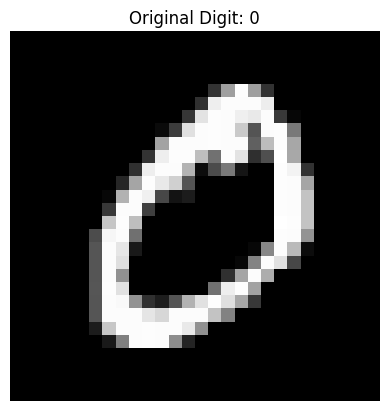

In [2]:
# Load MNIST (28x28 grayscale)
transform = transforms.Compose([
    transforms.ToTensor()
])

mnist = datasets.MNIST(root="mnist", train=True, download=False, transform=transform)
print("Loaded MNIST:", len(mnist), "samples")

# Pick one image
idx = 1
image, label = mnist[idx]
image = image.squeeze().numpy()
print("Image shape:", image.shape, "| Label:", label)

plt.imshow(image, cmap='gray')
plt.title(f"Original Digit: {label}")
plt.axis('off')
plt.show()


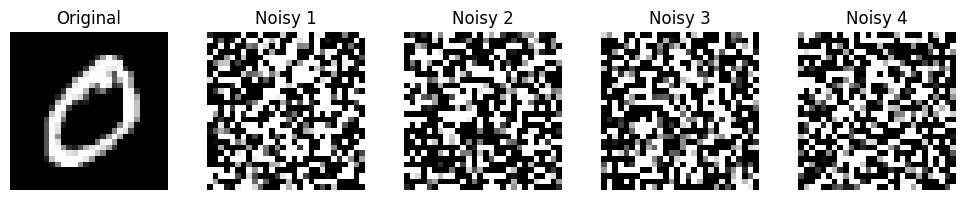

In [3]:
def add_gaussian_noise(img, mean=0, std=0.5):
    timesteps = 10
    for _ in range(timesteps):
        std = random.uniform(2, std)
        noise = np.random.normal(mean, std, img.shape)
        noisy = img + noise
    return np.clip(noisy, 0.0, 1.0)

# Generate 4 noisy versions of the same image, varying std
noisy_versions = [add_gaussian_noise(image, std=2) for _ in range(4)]

plt.figure(figsize=(10, 2))
plt.subplot(1, 5, 1)
plt.imshow(image, cmap='gray')
plt.title("Original")
plt.axis('off')

for i, n in enumerate(noisy_versions):
    plt.subplot(1, 5, i+2)
    plt.imshow(n, cmap='gray')
    plt.title(f"Noisy {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


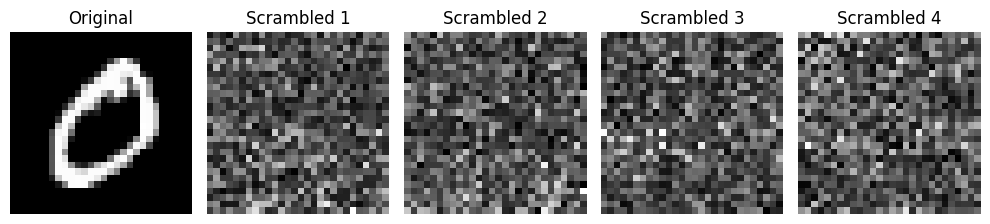

In [ ]:
from utils.haar_noising_script import fast_haar_scramble
from utils.angle_encoding_script import angle_encoding


def pad_to_power_of_two(vec, n_qubits):
    dim = 2 ** n_qubits
    v = np.copy(vec)
    if len(v) < dim:
        v = np.pad(v, (0, dim - len(v)), mode='constant')
    else:
        v = v[:dim]
    # normalize to unit norm
    v = v / np.linalg.norm(v)
    return v


num_samples = 10
num_scrambles = 4
n_qubits = 10
depth = 8
seed = 42

encoded_images = []
scrambled_versions_all = []
mnist_chunk = np.array([mnist[i][0].squeeze() for i in range(num_samples)])

for s in range(num_samples):
    encoded = angle_encoding(mnist_chunk, sample=s)
    encoded_images.append(encoded)

    # Flatten encoded image and pad/truncate (if dimension is not a power of 2)
    flat_encoded = encoded.flatten()
    flat_encoded = pad_to_power_of_two(flat_encoded, n_qubits)

    # Apply Haar scrambling (or the fast haar-like circuit) multiple times
    scrambles = [
        fast_haar_scramble(flat_encoded, n_qubits=n_qubits, depth=depth, seed=seed + k)
        for k in range(num_scrambles)
    ]
    scrambled_versions_all.append(scrambles)

# Visualize by sample
sample_idx = 1
original_image = mnist_chunk[sample_idx]

plt.figure(figsize=(10, 2.5))
plt.subplot(1, num_scrambles + 1, 1)
plt.imshow(original_image, cmap="gray")
plt.title("Original")
plt.axis("off")

for i, scrambled_state in enumerate(scrambled_versions_all[sample_idx]):
    scrambled_img = np.abs(scrambled_state[:28*28]).reshape(28, 28)
    plt.subplot(1, num_scrambles + 1, i + 2)
    plt.imshow(scrambled_img, cmap="gray")
    plt.title(f"Scrambled {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()
